## <center> Applied Machine Learning </center>
### <center> Faiza Fatma Siddiqui </center>
### <center> Date: 25-05-2022</center>

Importing the necessary libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time
from IPython import display

Checking if the gpu-accelarator is active

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

checking for the type of GPU provided by Colab.

In [3]:
!nvidia-smi

Wed May 25 03:10:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |    264MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Part A: Preparing and using the dataset

#### Load the MNIST Dataset

In [4]:
(x_train, y_train), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


#### Scale the training data into the range [0,1]

In [5]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train)/255  

#### Shuffle the dataset
#### Train the model by using the entire dataset multiple times

In [6]:
BUFFER_FOR_SHUFFLING = 60000
BATCH_SIZE = 90

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_FOR_SHUFFLING).batch(BATCH_SIZE)

### Part B: Create the models

#### The generator architecture is similar to the one shown in class

Making a function for creating GENERATOR MODEL

The sigmoid activation function is used.

In [8]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,), activation="sigmoid"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation="sigmoid"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation="sigmoid"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
  
    return model

Testing the generator model

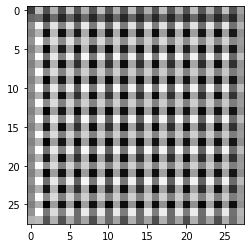

In [9]:
generator = build_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [11]:
generated_image[0, :, :, 0].shape

TensorShape([28, 28])

#### The discriminator architecture is similar to the one shown in class.

Making a function for creating DISCRIMINATOR MODEL

The sigmoid activation function is used 

In [12]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

In [13]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

Testing the DISCRIMINATOR MODEL

In [14]:
discriminator = build_discriminator()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49111146]], shape=(1, 1), dtype=float32)


#### A unique instance of the Adam optimizer is created for both the generator and discriminator

In [15]:
gen_opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
disc_opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

### Part C: Training the models

Defining Losses

In [16]:
binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Proper functions for the generator and discriminator loss functions exist

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = binary_cross_entropy_loss(tf.ones_like(real_output), real_output)
    fake_loss = binary_cross_entropy_loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def generator_loss(fake_output):
    return binary_cross_entropy_loss(tf.ones_like(fake_output), fake_output)

In [19]:
EPOCHS = 100
noiseDimensions = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noiseDimensions])

#### The loss functions are computed properly.

#### The gradients for the networks are computed and applied.

In [20]:
@tf.function
def firstEpochTrainingStep(images):
    noise = tf.random.normal([BATCH_SIZE, noiseDimensions])

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = generator_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = discriminator_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    print(gen_loss, disc_loss)

### Part D: Additional Functionality

#### A function exists to generate and save images created by the generator

In [21]:
def generate_and_save_images(model, epoch, input_):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(input_, training=False)

# Modify the outer loop of your training procedure to save the parameters 
# at some frequency, such as once every epoch or once every five epochs
  a=0
  if epoch%10==0 or epoch==1:
    fig = plt.figure(figsize=(4, 4))
    #saving the weights of the generator in every 10 epochs
    a+=1
    model.save_weights(f"generator{a}.ckpt")

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
        plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

#### Modify the outer loop of your training procedure to save the parameters at some frequency, such as once every epoch or once every five epochs

#### Part C: A compiled training step function is created

#### Part C: Create and use a training loop that loops over the entire dataset. Each iteration of the loop is referred to as an epoch

In [22]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      firstEpochTrainingStep(image_batch)

    # display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

### PART E: Evaluation of Model & Training

#### Part D: The average loss values are printed for epoch of training

#### The model begins training

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32) Tensor("add:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32) Tensor("add:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32) Tensor("add:0", shape=(), dtype=float32)


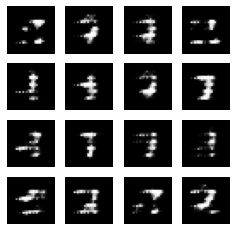

Time for epoch 1 is 14.155135154724121 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 2 is 10.608627796173096 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 3 is 10.669199705123901 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 4 is 10.78365182876587 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 5 is 10.903905630111694 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 6 is 10.990078687667847 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 7 is 11.105539083480835 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 8 is 11.18616008758545 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 9 is 11.289679288864136 sec


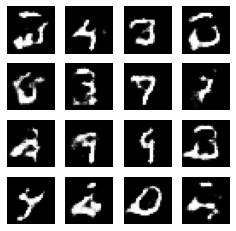

Time for epoch 10 is 11.93126893043518 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 11 is 11.450339794158936 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 12 is 11.469382047653198 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 13 is 11.43607759475708 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 14 is 11.398075342178345 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 15 is 11.364904642105103 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 16 is 11.367746114730835 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 17 is 11.399092674255371 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 18 is 11.41539478302002 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 19 is 11.434038162231445 sec


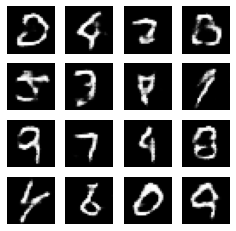

Time for epoch 20 is 11.871120691299438 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 21 is 11.43018913269043 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 22 is 11.42981505393982 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 23 is 11.412837743759155 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 24 is 11.410927772521973 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 25 is 11.413607597351074 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 26 is 11.421167612075806 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 27 is 11.412677764892578 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 28 is 11.429748058319092 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 29 is 11.43378210067749 sec


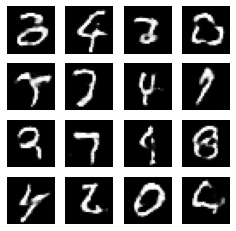

Time for epoch 30 is 11.81250810623169 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 31 is 11.418687105178833 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 32 is 11.412031412124634 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 33 is 11.419555425643921 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 34 is 11.409706354141235 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 35 is 11.41044282913208 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 36 is 11.410483121871948 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 37 is 11.408252239227295 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 38 is 11.439353942871094 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 39 is 11.419703960418701 sec


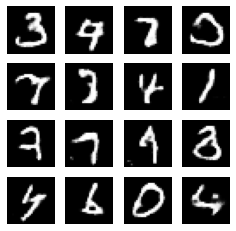

Time for epoch 40 is 12.013941049575806 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 41 is 11.408042430877686 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 42 is 11.422756671905518 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 43 is 11.425316333770752 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 44 is 11.417726516723633 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 45 is 11.419679880142212 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 46 is 11.405192136764526 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 47 is 11.412893295288086 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 48 is 11.396418333053589 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 49 is 11.414417266845703 sec


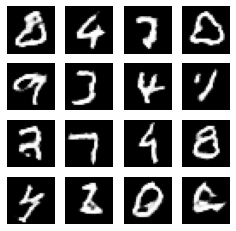

Time for epoch 50 is 11.783653020858765 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 51 is 11.400054693222046 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 52 is 11.397114038467407 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 53 is 11.399159908294678 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 54 is 11.384506464004517 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 55 is 11.386533975601196 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 56 is 11.380016565322876 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 57 is 11.39980149269104 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 58 is 11.407505512237549 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 59 is 11.397555828094482 sec


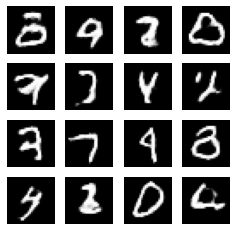

Time for epoch 60 is 11.772825479507446 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 61 is 11.424259185791016 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 62 is 11.41562271118164 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 63 is 11.41641354560852 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 64 is 11.417496681213379 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 65 is 11.43152642250061 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 66 is 11.420369863510132 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 67 is 11.422129154205322 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 68 is 11.400501728057861 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 69 is 11.418118715286255 sec


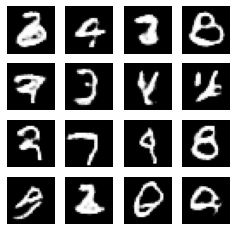

Time for epoch 70 is 11.786309719085693 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 71 is 11.392643451690674 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 72 is 11.386692523956299 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 73 is 11.414555549621582 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 74 is 11.391666412353516 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 75 is 11.38498568534851 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 76 is 11.389123678207397 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 77 is 11.386501789093018 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 78 is 11.401058435440063 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 79 is 11.3920419216156 sec


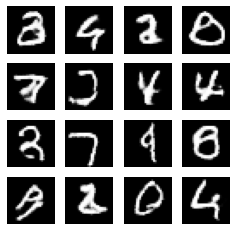

Time for epoch 80 is 11.992760181427002 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 81 is 11.397900104522705 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 82 is 11.408567905426025 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 83 is 11.40688443183899 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 84 is 11.41709017753601 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 85 is 11.428100824356079 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 86 is 11.417811393737793 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 87 is 11.429805278778076 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 88 is 11.422884464263916 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 89 is 11.421067953109741 sec


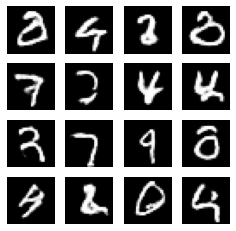

Time for epoch 90 is 11.804688215255737 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 91 is 11.417434215545654 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 92 is 11.418209552764893 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 93 is 11.42552661895752 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 94 is 11.4158616065979 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 95 is 11.42442536354065 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 96 is 11.415234088897705 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 97 is 11.425160884857178 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 98 is 11.43097734451294 sec


<Figure size 432x288 with 0 Axes>

Time for epoch 99 is 11.417829513549805 sec


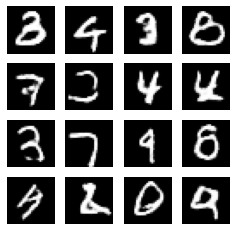

Time for epoch 100 is 11.800890922546387 sec


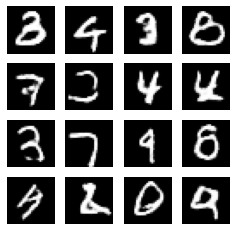

In [23]:
train(train_dataset, EPOCHS)

#### The generator can create over half of the digits in the MNIST dataset.

#### The GAN does not run into training errors within the first 3 epochs of training.

### Part D: Additional Functionality

#### A function exists to save the parameters of the generator and discriminator.

In [24]:
def save_generator_model(model):
  model.save("generator.h5")
  # generator.save("generator.h5")

def save_discriminator_model(model):
  model.save("discriminator.h5")
  # discriminator.save("discriminator.h5")

In [25]:
save_generator_model(generator)
save_discriminator_model(discriminator)

#### A function exists to load the parameters of the generator and discriminator.

In [26]:
def load_generator(path):
  return tf.keras.models.load_model(path)
def load_discriminator(path):
  return tf.keras.models.load_model(path)

generator_loaded = load_generator("/content/generator.h5")
discriminator_loaded = load_discriminator("/content/discriminator.h5")

In [27]:
generator_loaded, discriminator_loaded

(<keras.engine.sequential.Sequential at 0x7febc347ffd0>,
 <keras.engine.sequential.Sequential at 0x7fec268d8410>)

In [29]:
generator.save_weights("generator.ckpt")
discriminator.save_weights("discriminator.ckpt")

In [ ]:
%%shell 
jupyter nbconvert --to html /content/GeneralAdversarialNetwork.ipynb